## Music Genre Classification – Dual Approach (Tabular + Image)
## Author: Abdallah Elmarakby


Decision Tree Accuracy: 0.58
              precision    recall  f1-score   support

       blues       0.44      0.40      0.42        20
   classical       0.81      1.00      0.90        13
     country       0.57      0.48      0.52        27
       disco       0.67      0.57      0.62        21
      hiphop       0.50      0.73      0.59        15
        jazz       0.65      0.68      0.67        22
       metal       0.78      0.84      0.81        25
         pop       0.53      0.62      0.57        13
      reggae       0.50      0.30      0.38        23
        rock       0.38      0.43      0.40        21

    accuracy                           0.58       200
   macro avg       0.58      0.61      0.59       200
weighted avg       0.58      0.58      0.58       200


Random Forest Accuracy: 0.76
              precision    recall  f1-score   support

       blues       0.63      0.85      0.72        20
   classical       1.00      1.00      1.00        13
     country      

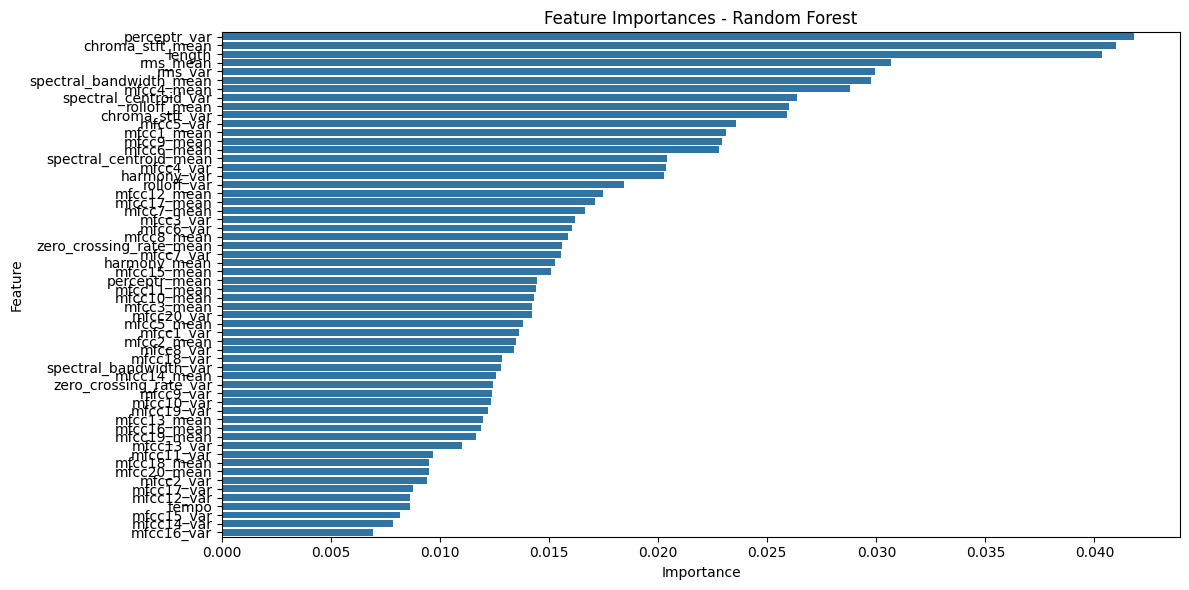

Saving world.wav to world.wav
Decision Tree Prediction: reggae
Random Forest Prediction: pop
Logistic Regression Prediction: pop


In [26]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from google.colab import files

# Step 2: Load dataset
# If you need to combine data from multiple files, you'll need a different approach.
try:
    df = pd.read_csv("/content/features_30_sec (1).csv")
except FileNotFoundError:
    print("'/content/features_30_sec (1).csv' not found. Using existing 'df' variable if available.")
    # If the file is not found, assume 'df' is already loaded in the environment


# Step 3: Encode labels
# Ensure df exists before proceeding
if 'df' in locals() or 'df' in globals():
    label_encoder = LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['label'])

    # Step 4: Prepare features and target
    X = df.drop(columns=['filename', 'label'])
    y = df['label']

    # Step 5: Normalize data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Step 6: Split data
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Step 7: Train models
    dt_model = DecisionTreeClassifier(random_state=42)
    dt_model.fit(X_train, y_train)

    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    lr_model = LogisticRegression(max_iter=1000)
    lr_model.fit(X_train, y_train)

    # Step 8: Evaluate models
    models = {'Decision Tree': dt_model, 'Random Forest': rf_model, 'Logistic Regression': lr_model}
    for name, model in models.items():
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print(f"\n{name} Accuracy: {acc:.2f}")
        print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    # Step 9: Feature importance for Random Forest
    importances = rf_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    features = X.columns

    plt.figure(figsize=(12, 6))
    sns.barplot(x=importances[indices], y=features[indices])
    plt.title("Feature Importances - Random Forest")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

    # Step 10: Upload an audio file
    uploaded = files.upload()
    file_path = list(uploaded.keys())[0]

    # Step 11: Extract all features from uploaded file to match training data
    def extract_all_features(file_path):
        y, sr = librosa.load(file_path, duration=30)
        features = {
            'length': len(y),
            'chroma_stft_mean': np.mean(librosa.feature.chroma_stft(y=y, sr=sr)),
            'chroma_stft_var': np.var(librosa.feature.chroma_stft(y=y, sr=sr)),
            'rms_mean': np.mean(librosa.feature.rms(y=y)),
            'rms_var': np.var(librosa.feature.rms(y=y)),
            'spectral_centroid_mean': np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)),
            'spectral_centroid_var': np.var(librosa.feature.spectral_centroid(y=y, sr=sr)),
            'spectral_bandwidth_mean': np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)),
            'spectral_bandwidth_var': np.var(librosa.feature.spectral_bandwidth(y=y, sr=sr)),
            'rolloff_mean': np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)),
            'rolloff_var': np.var(librosa.feature.spectral_rolloff(y=y, sr=sr)),
            'zero_crossing_rate_mean': np.mean(librosa.feature.zero_crossing_rate(y=y)),
            'zero_crossing_rate_var': np.var(librosa.feature.zero_crossing_rate(y=y))
        }
        # Extract MFCCs and add their means and variances
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        for i in range(20):
            features[f'mfcc{i+1}_mean'] = np.mean(mfccs[i])
            features[f'mfcc{i+1}_var'] = np.var(mfccs[i])
        return features

    audio_features = extract_all_features(file_path)
    audio_features_df = pd.DataFrame([audio_features]) # Convert to DataFrame to match scaler input

    # Step 12: Prepare feature vector
    # Ensure the order of columns matches the training data
    # Add missing columns with default values (e.g., 0) if necessary, though extracting all should prevent this
    for col in X.columns:
        if col not in audio_features_df.columns:
            audio_features_df[col] = 0 # Or some other appropriate default

    audio_features_df = audio_features_df[X.columns] # Reindex to ensure column order matches

    # Check if the number of features matches before scaling
    if audio_features_df.shape[1] != X.shape[1]:
        print(f"Error: Feature mismatch. Training data has {X.shape[1]} features, but extracted audio has {audio_features_df.shape[1]}.")
    else:
        mfcc_scaled = scaler.transform(audio_features_df)

        # Step 13: Predict genre using trained models
        for name, model in models.items():
            pred = model.predict(mfcc_scaled)
            genre = label_encoder.inverse_transform(pred)
            print(f"{name} Prediction: {genre[0]}")
else:
    print("DataFrame 'df' not found. Please load your data into a 'df' variable before running this cell.")